In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ipywidgets as widgets
from IPython.display import clear_output

In [2]:
plt.rcParams["figure.figsize"] = (10, 10)
plt.rcParams["font.size"] = 18

In [3]:
%load_ext jupyter_spaces

### Summary
We manage to get the straight edge between the regions and reduce the parameters to a minimum of 2, one for the number of borders and one is a scaling factor for the total mesh.


### Modified Lattice Generation
First we split the `generate_full_lattice_1_1D` function in a part that only generates the `lattice_array`: `generate_lattice_array_1_1D` and a part that generates the full lattice from the `lattice_array`: `generate_full_lattice_1_1D`.

We also add a check in `generate_full_lattice_1_1D` to verify, if the supplied `lattice_array` sets the same number of underlying cells for each time slice. Previously we did not require this to be true, but implicitly only worked with `lattice_arrays` that fulfilled this condition. Now, as we procedurally generate a lattice, invalid configuration might slip through. In fact, this already happened in the previous part with the flawed lattice. This error did not become visible, because of the way the lattice was configured.

In [4]:
def generate_lattice_array_1_1D(cells_areas, width_areas, dt_areas):
    """Generate the lattice array defining the layout.
    
    Args:
        cells_areas:
            Nested 2D Python list with width of each area
            in units of the stepping for that area.
        width_areas:
            Nested 2D Python list with spatial stepping
            for each area.
        dt_areas:
            Nested 2D Python list with temporal stepping
            for each erea.
    
    All arguments must share the same size for the outermost
    list and all sublists with the same position in their list
    must share the same size as well.
    
    Returns:
        Numpy array with Python lists as elements that fully
        characterizes the lattice. First dim is the number
        of time steps inherited from the arguments.
    """
    
    # find number of time steps Nt
    # take max so loop in next line raises error for wrong arguments
    time_steps = max(len(cells_areas), len(width_areas), len(dt_areas))

    l = np.empty(time_steps, dtype=object)
    for i in range(time_steps):
        l[i] = [[t, w, c] for t, w, c in zip(dt_areas[i], width_areas[i], cells_areas[i])]
        
    return l

In [5]:
def generate_full_lattice_1_1D(lattice_array):
    """Generate a Numpy array with the given cell layout.

    Args:
        lattice_array:
            Return value of `generate_lattice_array`. Numpy
            array with length equal the time steps and each
            element being a Python list of variable length
            containing Python lists of length 3.

    Returns:
        Multidimensional Numpy array representation of the
        lattice with `shape = (Nt, Ns, 2)`. Nt: number of
        time slices, Ns: number of spatial cells, both given
        for the finest resolution at any given time slice.
        First dim is time, second dim is space and third dim
        is [dt, ds].
    """
    # must only be 1D
    time_steps = lattice_array.shape[0]
    
    # find the finest spatial mesh:
    fine_mesh = 0
    for areas in lattice_array[0]:
        fine_mesh += areas[1] * areas[-1]

    # for 1+1D, innermost dim = 2
    full_lattice = np.empty((time_steps, fine_mesh, 2), dtype=np.int64)

    # using l as the lattice array
    mesh = np.empty((fine_mesh, 2))
    for i in range(time_steps):
        start = 0
        for areas in lattice_array[i]:
            # set time step for all elements
            mesh[start : start+areas[-1]*areas[1]] = [areas[0], 0]
            # set correct spatial step with proper stepping through mesh
            mesh[start : start+areas[-1]*areas[1] : areas[1]] = [areas[0], areas[1]]
            start += areas[-1]*areas[1]
        if start != fine_mesh:
            raise Exception(
                "Invalid lattice_array!\n"
                "The number of spatial cells varies between time steps!\n"
                f"{i=}, {lattice_array[i]=}, {fine_mesh=}"
            )
        full_lattice[i] = mesh

    # set subsequent time dims for cells with dt>1 to zero
    # just like for coarser spatial stepping
    for i, lt in enumerate(full_lattice):
        max_dt = np.max(lt[:, 0])
        for t in range(1, max_dt):
            full_lattice[i + t][lt[:, 0] > t, 0] = 0

    return full_lattice

In [6]:
def plot_mesh_1_1D(field, lattice):
    """Color a `lattice` with values from `field`.

    Args:
        field: Numpy array with field values to plot.
        lattice:
            Numpy array with lattice spacings for each site.
            Takes return value of `generate_full_lattice_1_1D`.

    All args have require `shape = (Nt, Ns, 2)`. Nt: number of
    time slices, Ns: number of spatial cells, both given for
    the finest resolution at any given time slice.
    
    Returns:
        Tuple of `(fig, ax)`, where `fig` is the generated
        Matplotlib figure and `ax` the axes with the plot.
    """

    fig, ax = plt.subplots()
    ax.set_aspect("equal")
    # ax.axes.xaxis.set_visible(False)
    # ax.axes.yaxis.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.patch.set_visible(False)
    # ax.set_frame_on(False)
    # this fixes missing lower and right boundary
    for spine in ax.spines.values():
        spine.set_edgecolor("gray")

    duration = field.shape[0]
    length = field.shape[1]

    ax.set_xlabel(r"$x\rightarrow$")
    ax.set_ylabel(r"$t\rightarrow$")

    # TODO:
    # change to addition to existing limits, to allow for iterative
    # application of this function on existing figures
    # ax.set_xlim(0, ax.get_xlims[-1] + np.max(np.sum(lattice[:, :, 1], 1)))
    
    # find limits based on fully varying lattice dimensions
    ax.set_xlim(0, np.max(np.sum(lattice[:, :, 1], 1)))
    ax.set_ylim(0, np.max(np.sum(lattice[:, :, 0], 0)))

    for t in range(duration):
        for x in range(length):

            value_positive = max(0, min(1, field[t, x]))
            value_negative = -1 * max(-1, min(0, field[t, x]))

            color = (
                1 - value_negative,
                1 - value_positive - value_negative,
                1 - value_positive,
            )  # rgb
            ax.add_patch(
                patches.Rectangle(
                    (np.sum(lattice[t, :x, 1]), np.sum(lattice[:t, x, 0])),
                    lattice[t, x, 1],
                    lattice[t, x, 0],
                    linewidth=1,
                    edgecolor="gray",
                    facecolor=color,
                )
            )

    return fig, ax

### Diagonal border mesh

First we try to fix the previous code and reproduce the flawed lattice.

In [7]:
%%space flawed_dynamic_diagonal_border_mesh
# plot adjustable number of diagonal boundaries to coarse mesh
def flawed_dynamic_diagonal_border_mesh(space_steps, coarse_factor, coarse_steps):
    # add first fine only time step
    time_steps = space_steps + coarse_factor**coarse_steps
    cells_areas = np.empty(time_steps, dtype=object)
    width_areas = np.empty(time_steps, dtype=object)
    start = list()
    s = [0,]
    
    # add first fine time slice
    for i in range(coarse_factor):
        cells_areas[i] = [space_steps,]
        width_areas[i] = [1,]

    for coa in range(1,coarse_steps +1):
        
        for t in range(1, time_steps//(coarse_factor**coa*coarse_steps) -1):
            for i in range(coarse_factor**coa):
                cells_areas[s[coa-1] + coarse_factor**coa*t + i] = [t,] + start[::-1] + [space_steps - s[coa-1] -t*coarse_factor**coa,]
                width_areas[s[coa-1] + coarse_factor**coa*t + i] = [ coarse_factor**cs for cs in range(coa, -1, -1) ]
        
        start.append(t+1)
        s.append(sum(coarse_factor**e*st for e,st in enumerate(start,1)))
        
        for i in range(min(coarse_factor**(coa+1), coarse_factor**coarse_steps)):
            cells_areas[s[coa] + i] = start[::-1] + [space_steps - s[coa],]
            width_areas[s[coa] + i] = [ coarse_factor**cs for cs in range(coa, -1, -1) ]
    
    # fix last (in terms of coarsest mesh) time slice
    for i in range(-coarse_factor**coarse_steps, 0):
        cells_areas[i] = [start[-1]+1,] + start[-2::-1]
        width_areas[i] = [ coarse_factor**cs for cs in range(coarse_steps, 0, -1) ]
        
    # allow only squares
    dt_areas = width_areas

    a = np.zeros((time_steps, space_steps))
    fill = (np.arange(0, a.size) - a.size / 2) / (a.size / 2)
    fill = fill.reshape(time_steps, space_steps)
    _, _ = plot_mesh_1_1D(
                fill, generate_full_lattice_1_1D(
                    generate_lattice_array_1_1D(cells_areas, width_areas, dt_areas)
                ))

# sliders
space_steps_slider = widgets.IntSlider(66,20,300,2)
coarse_factor_slider = widgets.IntSlider(2,2,16,2)
coarse_steps_slider = widgets.IntSlider(3,1,20)

# labels
space_steps_label = widgets.Label('# Total Spatial Cells')
coarse_factor_label = widgets.Label('Factor for Coarse Cell')
coarse_steps_label = widgets.Label('# Coarse Borders')

# plot mesh button
b = widgets.Button(description='Plot Lattice', tooltip='Click me')
plot_out = widgets.Output()
def click_button(b):
    plot_out.clear_output()
    with plot_out:
        flawed_dynamic_diagonal_border_mesh(
            space_steps=space_steps_slider.value,
            coarse_factor=coarse_factor_slider.value,
            coarse_steps=coarse_steps_slider.value
        )
        plt.show()
    
b.on_click(click_button)

# display everything
display(
    widgets.VBox([
    widgets.HBox([space_steps_label, space_steps_slider]),
    widgets.HBox([coarse_factor_label, coarse_factor_slider]),
    widgets.HBox([coarse_steps_label, coarse_steps_slider]),
    b
    ]))
display(plot_out)

Output()

What we actually want looks like this:

[list([[8, 8, 3], [4, 4, 6], [2, 2, 9]])
 list([[8, 8, 3], [4, 4, 6], [2, 2, 9]])
 list([[8, 8, 3], [4, 4, 6], [2, 2, 9]])
 list([[8, 8, 3], [4, 4, 6], [2, 2, 9]])
 list([[8, 8, 3], [4, 4, 5], [2, 2, 11]])
 list([[8, 8, 3], [4, 4, 5], [2, 2, 11]])
 list([[8, 8, 3], [4, 4, 5], [2, 2, 11]])
 list([[8, 8, 3], [4, 4, 5], [2, 2, 11]])
 list([[8, 8, 2], [4, 4, 6], [2, 2, 12], [1, 1, 2]])
 list([[8, 8, 2], [4, 4, 6], [2, 2, 12], [1, 1, 2]])
 list([[8, 8, 2], [4, 4, 6], [2, 2, 11], [1, 1, 4]])
 list([[8, 8, 2], [4, 4, 6], [2, 2, 11], [1, 1, 4]])
 list([[8, 8, 2], [4, 4, 5], [2, 2, 12], [1, 1, 6]])
 list([[8, 8, 2], [4, 4, 5], [2, 2, 12], [1, 1, 6]])
 list([[8, 8, 2], [4, 4, 5], [2, 2, 11], [1, 1, 8]])
 list([[8, 8, 2], [4, 4, 5], [2, 2, 11], [1, 1, 8]])
 list([[8, 8, 1], [4, 4, 6], [2, 2, 12], [1, 1, 10]])
 list([[8, 8, 1], [4, 4, 6], [2, 2, 12], [1, 1, 10]])
 list([[8, 8, 1], [4, 4, 6], [2, 2, 11], [1, 1, 12]])
 list([[8, 8, 1], [4, 4, 6], [2, 2, 11], [1, 1, 12]])
 list([[8, 8, 1], [4, 4, 5],

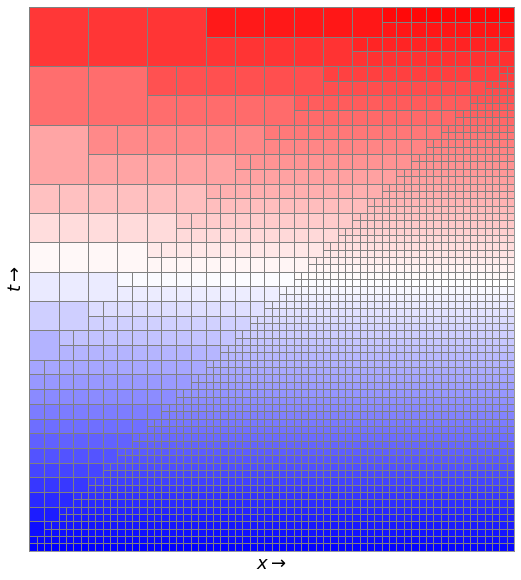

In [8]:
%%space desired_outcome
# This is the desired outcome
# all loops that require change are explicitly written out

coarse_steps = 3
coarse_factor = 2
# factor times coarse_factor**coarse_steps*coarse_steps
time_steps = 74

space_steps = time_steps - coarse_factor**coarse_steps
cells_areas = np.empty(time_steps, dtype=object)
width_areas = np.empty(time_steps, dtype=object)
start, sstart = list(), list()
s, ss = list(), list()

# cells_areas.fill([space_steps,])
# width_areas.fill([1,])

# add first fine time slice
for i in range(coarse_factor):
    cells_areas[i] = [space_steps,]
    width_areas[i] = [1,]

coa = 1
width_area = [ coarse_factor**cs for cs in range(coa, -1, -1) ]
for t in range(1, time_steps//(coarse_factor**coa*coarse_steps) +1):
    offset = sum(s) + coarse_factor**coa*t
    ttt = coarse_factor**coa*t
    coa1 = coa-1
#     for i in range(coarse_factor**coa1):
#         for j in range(coarse_factor):
    i = 0
    shift = [ start[k] if f"{i:{coa1}b}".replace(' ','0')[k]=='0' else sstart[k] for k in range(coa1) ]
    sum_shift = sum(coarse_factor**c*st for c,st in enumerate(shift[::-1],1))
    cells_areas[offset + 0] = [t,] + shift + [space_steps - sum_shift -ttt,]
    width_areas[offset + 0] = width_area
    cells_areas[offset + 1] = [t,] + shift + [space_steps - sum_shift -ttt,]
    width_areas[offset + 1] = width_area

        
start.insert(0,t-1)
sstart.insert(0,t)
s.insert(0,coarse_factor**coa*start[0])
ss.insert(0,coarse_factor**coa*sstart[0])

coa = 2
width_area = [ coarse_factor**cs for cs in range(coa, -1, -1) ]
for t in range(1, time_steps//(coarse_factor**coa*coarse_steps) +1):
    offset = sum(s) + coarse_factor**coa*t
    ttt = coarse_factor**coa*t
    coa1 = coa-1
#     for i in range(coarse_factor**coa1):
#         for j in range(coarse_factor):

    i = 0
    shift = [ start[k] if f"{i:{coa1}b}".replace(' ','0')[k]=='0' else sstart[k] for k in range(coa1) ]
    sum_shift = sum(coarse_factor**c*st for c,st in enumerate(shift[::-1],1))
    cells_areas[offset + 0] = [t,] + shift + [space_steps - sum_shift -ttt,]
    width_areas[offset + 0] = width_area
    cells_areas[offset + 1] = [t,] + shift + [space_steps - sum_shift -ttt,]
    width_areas[offset + 1] = width_area
    
    i=1
    shift = [ start[k] if f"{i:{coa1}b}".replace(' ','0')[k]=='0' else sstart[k] for k in range(coa1) ]
    sum_shift = sum(coarse_factor**c*st for c,st in enumerate(shift[::-1],1))
    cells_areas[offset + 2] = [t,] + shift + [space_steps - sum_shift -ttt,]
    width_areas[offset + 2] = width_area
    cells_areas[offset + 3] = [t,] + shift + [space_steps - sum_shift -ttt,]
    width_areas[offset + 3] = width_area
    
start.insert(0,t-1)
sstart.insert(0,t)
s.insert(0,coarse_factor**coa*start[0])
ss.insert(0,coarse_factor**coa*sstart[0])

coa=3
width_area = [ coarse_factor**cs for cs in range(coa, -1, -1) ]
for t in range(1, time_steps//(coarse_factor**coa*coarse_steps) +1):
    offset = sum(s) + coarse_factor**coa*t
    ttt = coarse_factor**coa*t
    coa1 = coa-1
#     for i in range(coarse_factor**(coa-1):
#         for j in range(coarse_factor):
    
    i = 0
    shift = [ start[k] if f"{i:{coa1}b}".replace(' ','0')[k]=='0' else sstart[k] for k in range(coa1) ]
    sum_shift = sum(coarse_factor**c*st for c,st in enumerate(shift[::-1],1))
    cells_areas[offset + 0] = [t,] + shift + [space_steps - sum_shift -ttt,]
    width_areas[offset + 0] = width_area
    cells_areas[offset + 1] = [t,] + shift + [space_steps - sum_shift -ttt,]
    width_areas[offset + 1] = width_area
    
    i=1
    shift = [ start[k] if f"{i:{coa1}b}".replace(' ','0')[k]=='0' else sstart[k] for k in range(coa1) ]
    sum_shift = sum(coarse_factor**c*st for c,st in enumerate(shift[::-1],1))
    cells_areas[offset + 2] = [t,] + shift + [space_steps - sum_shift -ttt,]
    width_areas[offset + 2] = width_area
    cells_areas[offset + 3] = [t,] + shift + [space_steps - sum_shift -ttt,]
    width_areas[offset + 3] = width_area
    
    i=2
    shift = [ start[k] if f"{i:{coa1}b}".replace(' ','0')[k]=='0' else sstart[k] for k in range(coa1) ]
    sum_shift = sum(coarse_factor**c*st for c,st in enumerate(shift[::-1],1))
    cells_areas[offset + 4] = [t,] + shift + [space_steps - sum_shift -ttt,]
    width_areas[offset + 4] = width_area
    cells_areas[offset + 5] = [t,] + shift + [space_steps - sum_shift -ttt,]
    width_areas[offset + 5] = width_area
    
    i=3
    shift = [ start[k] if f"{i:{coa1}b}".replace(' ','0')[k]=='0' else sstart[k] for k in range(coa1) ]
    sum_shift = sum(coarse_factor**c*st for c,st in enumerate(shift[::-1],1))
    cells_areas[offset + 6] = [t,] + shift + [space_steps - sum_shift -ttt,]
    width_areas[offset + 6] = width_area
    cells_areas[offset + 7] = [t,] + shift + [space_steps - sum_shift -ttt,]
    width_areas[offset + 7] = width_area

start.insert(0,t-1)
sstart.insert(0,t)
s.insert(0,coarse_factor**coa*start[0])
ss.insert(0,coarse_factor**coa*sstart[0])

# fix last (in terms of coarsest mesh) time slice
# the lattice array contains negative values, when the finest region is pushed outside of the "box"
# this will only work for the current limit on the time_steps
ttt = coarse_factor**coarse_steps*sstart[0]
for i in range(-coarse_factor**(coarse_steps-1), 0):
    
    width_area = [ coarse_factor**cs for cs in range(coarse_steps, 0, -1) ]
    for j in range(coarse_factor):
        cells_areas[2*i + j][-2] += cells_areas[2*i + j][-1]*width_areas[2*i + j][-1] +i + coarse_factor**(coarse_steps-1)
        
        cells_areas[2*i + j] = cells_areas[2*i + j][:-1]
        width_areas[2*i + j] = width_area

# allow only squares
dt_areas = width_areas

a = np.zeros((time_steps, space_steps))
fill = (np.arange(0, a.size) - a.size / 2) / (a.size / 2)
fill = fill.reshape(time_steps, space_steps)
_, _ = plot_mesh_1_1D(
            fill,
            full_lattice:=generate_full_lattice_1_1D(
                l:=generate_lattice_array_1_1D(cells_areas, width_areas, dt_areas)
            ))
print(l[::-1])

Which can be generalized for the `dynamic_diagonal_border_mesh`, which also contains some easy and obvious optimizations. The trick is to recognize the pattern of alternating numbers of cells (to get the straight edge) as the binary encoding of the row index `i`.

In [9]:
%%space dynamic_diagonal_border_mesh
# plot adjustable number of diagonal boundaries to coarse mesh
def dynamic_diagonal_border_mesh(space_steps, coarse_factor, coarse_steps):
    # add first fine only time step
    time_steps = space_steps + coarse_factor**coarse_steps
    cells_areas = np.empty(time_steps, dtype=object)
    width_areas = np.empty(time_steps, dtype=object)
    start, sstart = list(), list()
    s, ss = list(), list()
    sumstart = 0
    width_area = [1,]
    
    # add first fine time slice
    for i in range(coarse_factor):
        cells_areas[i] = [space_steps,]
        width_areas[i] = [1,]

    for coa in range(1,coarse_steps +1):
        cfc = coarse_factor**coa
        width_area.insert(0, cfc)
        end_t = int(np.ceil(time_steps/(cfc*coarse_steps)))
        
        for t in range(1, end_t):
            ttt = cfc*t
            offset = sumstart + ttt
            coa1 = coa-1
            
            for i in range(coarse_factor**coa1):
                # the binary encoding of alternating rows
                binn = f"{i:{coa1}b}".replace(' ','0')
                shift = [ start[k] if binn[k]=='0' else sstart[k] for k in range(coa1) ]
                sum_shift = sum(coarse_factor**c*st for c,st in enumerate(shift[::-1],1))
                cells_area = [t,] + shift + [space_steps - sum_shift -ttt,]
            
                for j in range(coarse_factor):
                    cells_areas[offset + 2*i + j] = cells_area[:]
                    width_areas[offset + 2*i + j] = width_area[:]
                    
        start.insert(0,t-1)
        sstart.insert(0,t)
        s.insert(0,cfc*start[0])
        sumstart += s[0]
        ss.insert(0,cfc*sstart[0])
        
    # fix last (in terms of coarsest mesh) time slice
    ttt = coarse_factor**coarse_steps*sstart[0]
    width_area = [ coarse_factor**cs for cs in range(coarse_steps, 0, -1) ]
    
    for i in range(-coarse_factor**(coarse_steps-1), 0):
        ii = i + coarse_factor**(coarse_steps-1)
        
        for j in range(coarse_factor):
            cells_areas[2*i + j][-2] += cells_areas[2*i + j][-1]*width_areas[2*i + j][-1] + ii
            cells_areas[2*i + j] = cells_areas[2*i + j][:-1]
            width_areas[2*i + j] = width_area[:]

    # allow only squares
    dt_areas = width_areas

    a = np.zeros((time_steps, space_steps))
    fill = (np.arange(0, a.size) - a.size / 2) / (a.size / 2)
    fill = fill.reshape(time_steps, space_steps)
    _, _ = plot_mesh_1_1D(
                fill,
                generate_full_lattice_1_1D(
                    generate_lattice_array_1_1D(cells_areas, width_areas, dt_areas)
                ))

# sliders
space_steps_slider = widgets.IntSlider(66,20,300,2)
coarse_factor_slider = widgets.IntSlider(2,2,16,2)
coarse_steps_slider = widgets.IntSlider(3,1,20)

# labels
space_steps_label = widgets.Label('# Total Spatial Cells')
coarse_factor_label = widgets.Label('Factor for Coarse Cell')
coarse_steps_label = widgets.Label('# Coarse Borders')

# plot mesh button
b = widgets.Button(description='Plot Lattice', tooltip='Click me')
plot_out = widgets.Output()
def click_button(b):
    plot_out.clear_output()
    with plot_out:
        dynamic_diagonal_border_mesh(
            space_steps=space_steps_slider.value,
            coarse_factor=coarse_factor_slider.value,
            coarse_steps=coarse_steps_slider.value
        )
        plt.show()
    
b.on_click(click_button)

# display everything
display(
    widgets.VBox([
    widgets.HBox([space_steps_label, space_steps_slider]),
    widgets.HBox([coarse_factor_label, coarse_factor_slider]),
    widgets.HBox([coarse_steps_label, coarse_steps_slider]),
    b
    ]))
display(plot_out)

Output()

### Adjustable Parameters
Still there are a lot of combinations that result in invalid configurations. Restricting the parameters to only the number of borders and a scaling factor for the size is enough to construct all possible meshes.
In the following the `coarse_factor` is also set to 2, as other values are not working anyway (and are also not required).

The size of the lattice (=`space_steps`) can be calculated from these two parameters by using the following equation, with the abbreviations:
- space_steps = ss
- time_steps = ts
- coarse_steps = cs
- scale = f
$$
\begin{equation}
\text{ss} = 2^{\text{cs}} \left[ \text{f} \left( \sum_{i=0}^{\text{cs} -1} 2^{-i} \right) -1 \right] +2
\end{equation}
$$

We derive this formula in the following. We start by summarizing the until now only implicitly included restrictions the lattice has to fulfill. They are not representative of the physics involved, but include symmetry consideration.

The first restriction is that the diagonal boundary is drawn from the lower left to the top right, where the entire area under the boundary shall be drawn as the finest mesh of the lattice. For this to be possible, the lattice has to have ts >=ss, so that the diagonal boundary reaches the top right corner.  
Additionally the last time slice in terms of the coarsest mesh should not contain any cells of the finest mesh, which gives rise to ts >=ss.

The second restriction is that the first time slice only consists of the finest mesh.

The third restriction is, that the differently scaled regions all share the same temporal width when measured in units of the finest mesh at the first cell ($x=0$). This splits the time steps equally between the coarser regions.

From the first condition follows
$$
\text{ts} = \text{ss} + 2^{\text{cs}}.
$$
Combining this equation with the other conditions yields
$$
\frac{\text{ts}-2}{\text{cb}} = x \sum_{i=0}^{\text{cs} -1} 2^{-i}.
$$
The quotient on the left hand side results from condition two and the fact that the remaining time slices then have to be split equally between all coarse regions. The equality holds as long as each region (on the time axis for $x=0$) can be built from powers of 2. Here the number 2 is the scaling factor each coarse region carries w.r.t. the previous one.

Rearranging the last result for ss will give the initially presented result.

In [10]:
%%space strict_diagonal_border_mesh
# plot adjustable number of diagonal boundaries to coarse mesh
def dynamic_diagonal_border_mesh(coarse_steps, scale, coarse_factor=2):
    
    # determine lattice dimensions
    space_steps = coarse_factor**coarse_steps * (scale *sum(coarse_factor**(-i) for i in range(coarse_factor-1)) -1) + coarse_factor
    time_steps = int(space_steps) + coarse_factor**coarse_steps
    cells_areas = np.empty(time_steps, dtype=object)
    width_areas = np.empty(time_steps, dtype=object)
    start, sstart = list(), list()
    s, ss = list(), list()
    sumstart = 0
    width_area = [1,]
    
    # add first fine time slice
    for i in range(coarse_factor):
        cells_areas[i] = [space_steps,]
        width_areas[i] = [1,]

    for coa in range(1,coarse_steps +1):
        cfc = coarse_factor**coa
        width_area.insert(0, cfc)
        end_t = int(np.ceil(time_steps/(cfc*coarse_steps)))
        
        for t in range(1, end_t):
            ttt = cfc*t
            offset = sumstart + ttt
            coa1 = coa-1
            
            for i in range(coarse_factor**coa1):
                # the binary encoding of alternating rows
                binn = f"{i:{coa1}b}".replace(' ','0')
                shift = [ start[k] if binn[k]=='0' else sstart[k] for k in range(coa1) ]
                sum_shift = sum(coarse_factor**c*st for c,st in enumerate(shift[::-1],1))
                cells_area = [t,] + shift + [space_steps - sum_shift -ttt,]
            
                for j in range(coarse_factor):
                    cells_areas[offset + 2*i + j] = cells_area[:]
                    width_areas[offset + 2*i + j] = width_area[:]
                    
        start.insert(0,t-1)
        sstart.insert(0,t)
        s.insert(0,cfc*start[0])
        sumstart += s[0]
        ss.insert(0,cfc*sstart[0])
        
    # fix last (in terms of coarsest mesh) time slice
    ttt = coarse_factor**coarse_steps*sstart[0]
    width_area = [ coarse_factor**cs for cs in range(coarse_steps, 0, -1) ]
    
    for i in range(-coarse_factor**(coarse_steps-1), 0):
        ii = i + coarse_factor**(coarse_steps-1)
        
        for j in range(coarse_factor):
            cells_areas[2*i + j][-2] += cells_areas[2*i + j][-1]*width_areas[2*i + j][-1] + ii
            cells_areas[2*i + j] = cells_areas[2*i + j][:-1]
            width_areas[2*i + j] = width_area[:]

    # allow only squares
    dt_areas = width_areas

    a = np.zeros((time_steps, space_steps))
    fill = (np.arange(0, a.size) - a.size / 2) / (a.size / 2)
    fill = fill.reshape(time_steps, space_steps)
    _, _ = plot_mesh_1_1D(
                fill,
                generate_full_lattice_1_1D(
                    generate_lattice_array_1_1D(cells_areas, width_areas, dt_areas)
                ))

# sliders
scale_slider = widgets.IntSlider(9,1,30)
coarse_steps_slider = widgets.IntSlider(3,1,20)
_ = widgets.link((scale_slider, 'min'), (coarse_steps_slider, 'value'))
_ = widgets.link((scale_slider, 'step'), (coarse_steps_slider, 'value'))

scale_slider.value = 9
coarse_steps_slider.value = 3

# labels
scale_label = widgets.Label('Scaling Factor')
coarse_steps_label = widgets.Label('Coarse Borders')

# plot mesh button
b = widgets.Button(description='Plot Lattice', tooltip='Click me')
plot_out = widgets.Output()
def click_button(b):
    plot_out.clear_output()
    with plot_out:
        dynamic_diagonal_border_mesh(
            coarse_steps=coarse_steps_slider.value,
            scale=scale_slider.value,
        )
        plt.show()
    
b.on_click(click_button)

# display everything
display(
    widgets.VBox([
    widgets.HBox([coarse_steps_label, coarse_steps_slider]),
    widgets.HBox([scale_label, scale_slider]),
    b
    ]))
display(plot_out)

Output()